## IMPORT RELEVANT LIBRARIES

In [1]:
# DATA EXTRACTION
import glob
import os

# Data Manipulation
import numpy as np
import pandas as pd

# Data Visulization
from    missingno import matrix
from    skimpy    import skim
import  matplotlib.pyplot as plt
import  seaborn as sns 

# Data Information 

#### Class information
<img src="data types.jpg">



## DATA EXTRACTION 

- Collect the directories of all files 
- Obtain each data
- Aggregate data by choosen metric 
    - Time range - 5 Minutes
    - Aggregator - Median
- Join all in a data frame using a loop and the pd.concat statement

In [2]:
# Establish root dir wher files resides
# This depends on your PC, Find the directory to the 3W folder
root_dir = r"C:\Users\Owner\Desktop\IT\Group project - W3\3W"

# Get all file Diretiories 
directiories = []
for i in range(0,9):
    directiories.append(root_dir  + f'\\{i}')

# Extract all file names directories 
files = []
for dir_name in directiories:
    files = files + glob.glob(os.path.join(dir_name, "*.csv"))

## DATA WRANGLING
- Data aggregation by hours   and class
- Data aggregation(use median for agg, or use max - min/2 ) by minutes(1, 10) and class


In [3]:
def data_collect(directory, time ,style ):
    '''
    This code aggregates each individual file 
    
    styles include - median, midrange, max, min, mode
    
    '''
    return pd.read_csv(directory, parse_dates= [0]).resample(time, on = 'timestamp').agg(style).reset_index()
    

def joinall(files, time = '10T', style = 'median'):
    '''
    This code block empasizes om joining each aggregated dataframe together
    '''
    
    ct = 0
    
    for dir_ in files:
         
        if ct == 0 :
            df = data_collect(dir_ , time, style)    
        else:
            df = pd.concat([df,data_collect(dir_, time, style)], axis = 0)
            
        ct+= 1
        
    return df.reset_index(drop =True)

In [4]:
df = joinall(files, time = '1T', style = 'median')
df.to_csv('combined_1mins_median.csv', index = False)

## DATA CLEANING 

> - check for speling inconsitencies -- There are no string to check for inconsitencies
> - check is missing /null data 
> - check or duplicates
> - check for data types

In [5]:
# Have a glimpse of the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850591 entries, 0 to 850590
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   timestamp   850591 non-null  datetime64[ns]
 1   P-PDG       850520 non-null  float64       
 2   P-TPT       850517 non-null  float64       
 3   T-TPT       753558 non-null  float64       
 4   P-MON-CKP   831839 non-null  float64       
 5   T-JUS-CKP   822128 non-null  float64       
 6   P-JUS-CKGL  169005 non-null  float64       
 7   T-JUS-CKGL  0 non-null       float64       
 8   QGL         180531 non-null  float64       
 9   class       850556 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 64.9 MB


<AxesSubplot:>

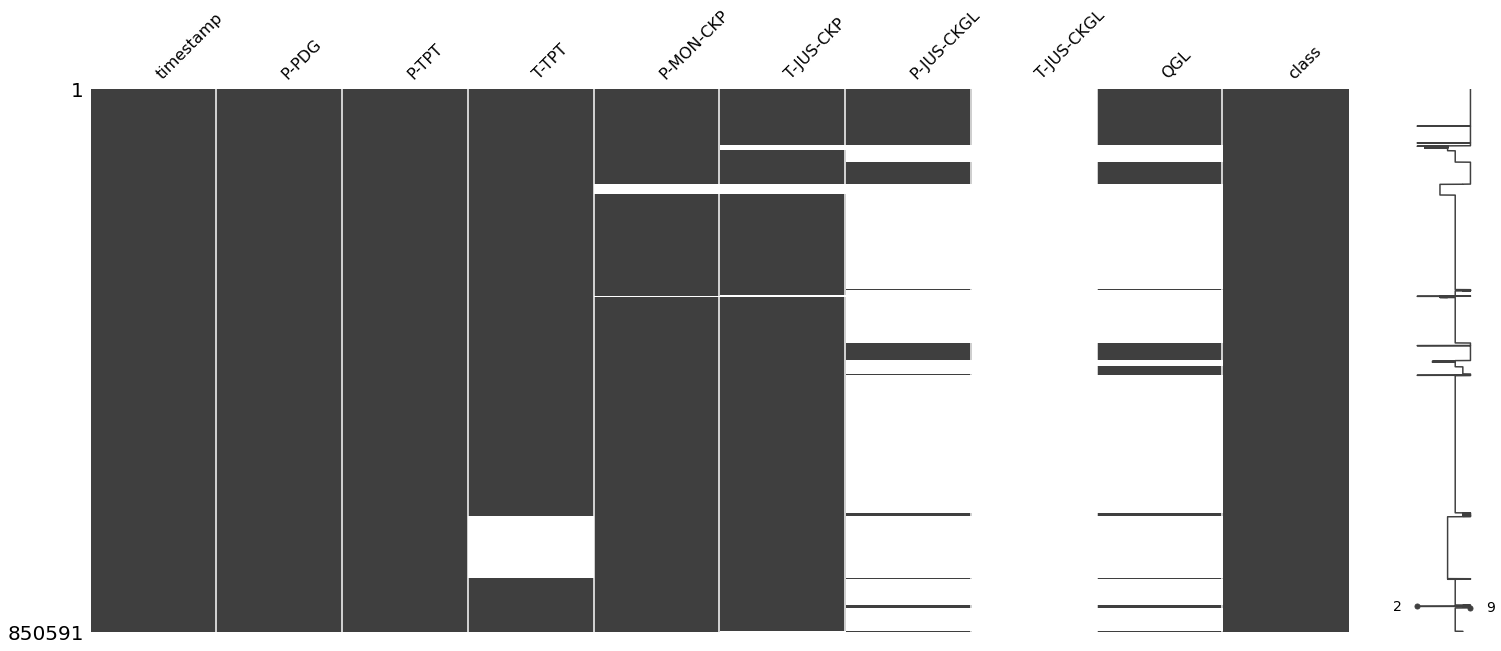

In [6]:
# Disover requencies of misssing data visually
matrix(df)

In [7]:
# Percentage of missing values per column

def per_missing(df):
    '''
    Finds the percentage of missing values in each column
    '''
    tot_len = len(df)
    
    per_missing = df.isna().sum().to_frame()
    per_missing['% missing'] = (per_missing[0]/tot_len) *100
    return per_missing.drop(columns = [0]).sort_values(by = ['% missing'], ascending= False)

per_missing(df)

,% missing
T-JUS-CKGL,100.000000
P-JUS-CKGL,80.130874
QGL,78.775816
T-TPT,11.407715
T-JUS-CKP,3.346262
P-MON-CKP,2.204585
P-TPT,0.008700
P-PDG,0.008347
class,0.004115
timestamp,0.000000


##### There are 3 Columns with alot of missing data(> 50%)
> - P-JUS-CKGL     
> - T-JUS-CKGL     
> - QGL    
Solution - Drop Columns
***

##### Others have just a few(>1% but < 15%>)
> - T-TPT    - check if the missing data are from the same class      
>     - yes , drop columns or drop class(opt)
>     - no  , fill with iterative imputer  
> - P-MON-CKP      
> - T-JUS-CKP  
Solution -  fill missing with Sklearn.iterative_imputer 
***

Also, the class column has some missing column 
Solution - drop rows with missing class
Lets Check the pecentage of missing data in those columns 

In [8]:
# Explore T-TPT columnsdf
missing_T_TPT_class =  df['class'][df['T-TPT'].isna()]
missing_T_TPT_class.value_counts().sort_index()

0.0       6593
3.0          8
4.0          9
6.0      64547
53.0         5
56.0         4
106.0    25862
107.0        5
Name: class, dtype: int64

In [9]:
# We see that the class 6 - Quick Restriction in PCK has alot of missing data
# Our quick guess is to check the percentage of missing data comes from the class = 6

missing_TPT = (64547 + 25862)/(len(df[df['class'] == 6]) + len(df[df['class'] == 106]))

print(f'{(missing_TPT * 100): 1f}% of TPT values that cointains 6 or 106 are missing')

# This simply implies that ue cannot use the T-TPT column if we want to classify the a condition, it will certainly be baised

"""
POSSIBLE SOLUTIONS 
 - Drop all values that cointain 6 or 106, there fore limiting the ability to predict that condition
 - Drop the T-TPT column 
"""
df1 = df.drop(columns=['T-JUS-CKGL','P-JUS-CKGL','QGL','T-TPT'])

 99.637418% of TPT values that cointains 6 or 106 are missing


#### CLEANING CLASS COLUMN

In [10]:
df1['class'].value_counts().sort_index()

0.0      200642
1.0       48495
2.0        6056
3.0       80677
4.0       41477
5.0      176064
6.0       64767
7.0        1812
8.0       10135
50.5          2
51.0          2
52.5          7
53.0          5
54.0          1
55.0          9
56.0          4
101.0     87975
102.0      2446
105.0     40346
106.0     25971
107.0     38365
108.0     25298
Name: class, dtype: int64

In [11]:
#compare the use of foward and backward fill
df2 = df1[['class','timestamp']].copy()
df2['backfill']  = df2['class'].fillna(method='backfill')
df2['ffill']     = df2['class'].fillna(method='pad')

df2.iloc[list(df1[df1['class'].isna()].index), -2:]

,backfill,ffill
314811,1.0,101.0
315151,101.0,0.0
315152,101.0,0.0
315153,101.0,0.0
315154,101.0,0.0
315155,101.0,0.0
315156,101.0,0.0
315805,101.0,0.0
315806,101.0,0.0
316157,1.0,101.0


> The nulls, look so much as the transient periods between a normal and a steady state.
> Without much certainty of this is, where this chages resides and considering it is a very minute portion os the data set,
> it would be best to drop nulls

In [12]:
#Find null class --- There are no null classes 
print('There are',df1['class'].isna().sum(), 'missing values in the class column')
print('which is',(df1['class'].isna().sum()/len(df1))*100, 'of the entire data')

There are 35 missing values in the class column
which is 0.004114786072272103 of the entire data


In [13]:
# The classes 10 - 100 are error, considering our class information, so we drop then
# Since class are our target variables, it would not be a great to fill it 
# This also drp the null values
df1  = (df1[(df1['class'] < 10) | (df1['class'] > 100)])

In [14]:
# Filter out all null values 
df1 = df1[df1['class'].notna()]
per_missing(df1)

,% missing
T-JUS-CKP,3.346400
P-MON-CKP,2.204753
P-TPT,0.008700
P-PDG,0.008348
timestamp,0.000000
class,0.000000


In [18]:
df1.iloc[:,1:].copy()

,P-PDG,P-TPT,P-MON-CKP,T-JUS-CKP,class
0,0.000000e+00,1.008923e+07,1721163.0,84.39386,0.0
1,0.000000e+00,1.008300e+07,1534360.5,84.07441,0.0
2,0.000000e+00,1.007636e+07,1574322.5,84.22451,0.0
3,0.000000e+00,1.007816e+07,1492020.5,84.05682,0.0
4,0.000000e+00,1.008318e+07,1614639.5,84.71115,0.0
...,...,...,...,...,...
850586,3.096968e+09,1.957242e+09,2930446.5,NaN,8.0
850587,3.096824e+09,1.955140e+09,3119260.5,NaN,8.0
850588,3.096738e+09,1.953528e+09,3150657.0,NaN,8.0
850589,3.096697e+09,1.944838e+09,3150677.0,NaN,8.0


In [36]:
from sklearn.experimental   import enable_iterative_imputer
from sklearn.impute         import IterativeImputer
from catboost               import CatBoostRegressor

df2 = df1.iloc[:,1:].copy()

imputer = IterativeImputer( estimator = CatBoostRegressor(learning_rate= 1, subsample=0.95),
                            verbose   = 2,
                            max_iter  = 20,
                            imputation_order = 'ascending'
                           )


pd.DataFrame(imputer.fit_transform(df2), columns = df2.columns) # preserve the column name

[IterativeImputer] Completing matrix with shape (850526, 5)
0:	learn: 36.7533612	total: 263ms	remaining: 4m 23s
1:	learn: 35.4560771	total: 573ms	remaining: 4m 45s
2:	learn: 34.2883359	total: 1.31s	remaining: 7m 17s
3:	learn: 33.7475114	total: 1.73s	remaining: 7m 10s
4:	learn: 33.2881932	total: 2.15s	remaining: 7m 6s
5:	learn: 32.8608504	total: 2.84s	remaining: 7m 50s
6:	learn: 32.5283099	total: 3.44s	remaining: 8m 8s
7:	learn: 32.3003955	total: 3.89s	remaining: 8m 2s
8:	learn: 32.1355170	total: 4.21s	remaining: 7m 43s
9:	learn: 31.7270829	total: 4.7s	remaining: 7m 45s
10:	learn: 31.4610203	total: 5.05s	remaining: 7m 34s
11:	learn: 31.2029501	total: 5.53s	remaining: 7m 35s
12:	learn: 30.9871711	total: 6.12s	remaining: 7m 44s
13:	learn: 30.7179136	total: 6.76s	remaining: 7m 55s
14:	learn: 30.5442920	total: 7.25s	remaining: 7m 56s
15:	learn: 30.4128578	total: 7.58s	remaining: 7m 46s
16:	learn: 30.3128729	total: 7.86s	remaining: 7m 34s
17:	learn: 30.2001953	total: 8.19s	remaining: 7m 26s


CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/algo/tensor_search_helpers.cpp:543: Too few sampling units (subsample=0.95, bootstrap_type=MVS): please increase sampling rate or disable sampling

## DATA WRANGLING 
> - CONVERT CLASS TO INTEGERS 
> - CONVERT TIMESTAMP TO DATETIME
> - CREATE CLASS_TYPE COLUMN
> - CREATE FAULT_TYPE COLUMN

In [ ]:
# CONVERT CLASS TO INTEGERS
df1['class'] = df1['class'].astype(int)

# CONVERT TIMESTAMP TO DATETIME
df1['timestamp'] = pd.to_datetime(df1['timestamp'])

In [ ]:
# CREATE CLASS_TYPE COLUMN
def class_type(x):
    
    if x == 0:
        return 'Normal'
    elif 0 < x < 10:
        return 'Faulty'
    else :
        return 'Transient'
    
df1['Class_type'] = df1['class'].apply(class_type)

In [ ]:

faults = {  0:'Normal' ,
            1:'Abrupt Increase of BSW' ,
            2:'Spurious Closure of DHSV' ,
            3:'Severe Slugging' ,
            4:'Flow Instability' ,
            5:'Rapid Productivity Loss' ,
            6:'Quick Restriction  in PCK',
            7:'Scaling in PCK',
            8:'Hydrate in Production Line'}

transient = {101 : 'To Fault 1',  
             102 : 'To Fault 2' , 
             105 : 'To Fault 3',  
             106 : 'To Fault 6',  
             107 : 'To Fault 7',  
             108 : 'To Fault 8',  }

fault_transient  = faults | transient

# CREATE FAULT_TYPE or TRANSIENT TYPE COLUMN
df1['Fault_Type'] = df1['class'].map(fault_transient)

In [ ]:
print(

## EXPLORATORY DATA ANALYSIS and  more Data Cleaning 
- Use skim to summeraize data
- Find Correlation using heatmap
- outlier detection - Boxplots 
- Scatterplots and violinplots for trends 
- Consider if ther is are trends with time 
- 
- Use pairplot to find trends
- 
-


In [ ]:
df1['Class_type'].value_counts().plot(kind = 'bar')

In [ ]:
df1['class'][df1['Class_type'] == 'Faulty'].value_counts().sort_index().plot(kind = 'bar')

In [ ]:
df1['class'][df1['Class_type'] == 'Transient'].value_counts().sort_index().plot(kind = 'bar')

In [ ]:
skim(df1)

In [ ]:
##create correlation table 
df_corr = df1.corr()

##create mask to remove upper boundaries 
mask = np.zeros_like(df_corr, dtype = bool)
mask[np.triu_indices_from(mask)]= True

##plot heatmap
f, ax = plt.subplots(figsize=(11, 15))
sns.heatmap(df_corr, annot=True, fmt='.2f', mask=mask, 
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
#add the column names as labels
ax.set_yticklabels(df_corr.columns, rotation = 0)
ax.set_xticklabels(df_corr.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [ ]:


#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2)

#create boxplot in each subplot
sns.boxplot(data = df1 , y = 'P-PDG',    x = 'Class_type',  ax=axes[0,0])
sns.boxplot(data = df1 , y = 'P-TPT',    x = 'Class_type',  ax=axes[0,1])
sns.boxplot(data = df1 , y = 'P-MON-CKP',x = 'Class_type',  ax=axes[1,0])
sns.boxplot(data = df1 , y = 'T-JUS-CKP',x = 'Class_type',  ax=axes[1,1])

In [ ]:
def class_distribution(param):
    
    return df1[[param, 'Class_type']].groupby('Class_type').quantile(np.linspace(0,0.01,11)).unstack()


flt_var = ['P-PDG', 'P-TPT', 'P-MON-CKP' , 'T-JUS-CKP']

class_distribution(flt_var[0])

In [ ]:
df1[df1['P-PDG'] < 0]

## FEATURE EXTRACTION 
- 

## MODEL CREATION
- 